# Financial Analysis with the `stock_analysis` package

The [`stock_analysis`](https://github.com/stefmolin/stock-analysis) package can be used for basic technical analysis of financial assets. Here is a breakdown of the classes and their purposes:

| Purpose | Class(es) | Module |
| --- | --- | --- |
| Collecting the data from various sources | `StockReader` | `stock_reader.py` |
| Visualizing the data | `Visualizer`, `StockVisualizer`, `AssetGroupVisualizer` | `stock_visualizer.py` |
| Calculating financial metrics | `StockAnalyzer`, `AssetGroupAnalyzer` | `stock_analyzer.py` |
| Modeling the data | `StockModeler` | `stock_modeler.py` |


## Data Collection

The `StockReader` class in the `stock_analysis` package makes it easy to collect financial data, like stock market or bitcoin prices. We simply have to create an instance by specifying the date range. Then, we can grab the data:

In [1]:
import stock_analysis

reader = stock_analysis.StockReader('2019-01-01', '2020-12-31')

# Get faang data
fb, aapl, amzn, nflx, goog = (
    reader.get_ticker_data(ticker)
    for ticker in ['FB', 'AAPL', 'AMZN', 'NFLX', 'GOOG']
)

# Get S&P 500 data
sp = reader.get_index_data('S&P 500')

# Get bitcoin data in USD
bitcoin = reader.get_bitcoin_data('USD')

## EDA
We can group our assets together in dataframes in order to perform EDA:

In [2]:
from stock_analysis.utils import group_stocks, describe_group

faang = group_stocks(
    {
        'Facebook': fb, 
        'Apple': aapl, 
        'Amazon': amzn, 
        'Netflix': nflx, 
        'Google': goog
    }
)

faang_sp = group_stocks(
    {
        'Facebook': fb, 
        'Apple': aapl, 
        'Amazon': amzn, 
        'Netflix': nflx, 
        'Google': goog,
        'S&P 500': sp
    }
)

all_assets = group_stocks(
    {
        'Bitcoin': bitcoin,
        'S&P 500': sp,
        'Facebook': fb, 
        'Apple': aapl, 
        'Amazon': amzn, 
        'Netflix': nflx, 
        'Google': goog
    }
)


This makes it easy to describe them all at once:

In [3]:
describe_group(all_assets).loc['close',]

name,Amazon,Apple,Bitcoin,Facebook,Google,Netflix,S&P 500
count,505.000000,505.000000,727.000000,505.000000,505.000000,505.000000,505.000000
mean,2235.904988,73.748386,9252.825408,208.146574,1335.188544,387.966593,3065.907599
std,594.306346,27.280933,4034.014685,39.665111,200.793911,78.931238,292.376435
min,1500.280029,35.547501,3399.471680,131.740005,1016.059998,254.589996,2237.399902
25%,1785.660034,50.782501,7218.593750,180.029999,1169.949951,329.089996,2870.719971
50%,1904.280029,66.730003,9137.993164,196.770004,1295.280029,364.369995,3005.469971
75%,2890.300049,91.632500,10570.513184,235.940002,1476.229980,469.959991,3276.020020
max,3531.449951,136.690002,29001.720703,303.910004,1827.989990,556.549988,3756.070068


### Visualizations
The `StockVisualizer` class makes it easy to create a variety of visualizations for financial analysis. We simply pass in the dataframe of the asset we want to visualize:

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

netflix_viz = stock_analysis.StockVisualizer(nflx)
utils_viz = stock_analysis.Visualizer()

We can use the moving average to smooth out the trend for the stock. Notice that, in the shaded region, the 90-day moving average is acting like a ceiling for the stock price:

[Text(0.5, 1.0, 'Netflix Closing Price'), Text(0, 0.5, 'price ($)')]

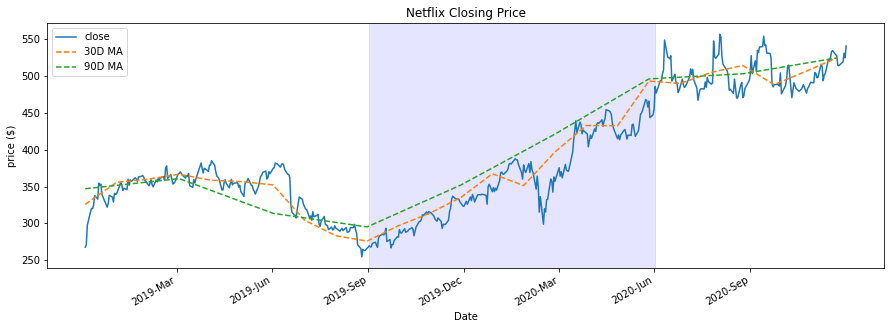

In [5]:
ax = netflix_viz.plot_moving_averages(
    type_='MA',
    column='close', 
    periods=['30D', '90D'],
)

ax = utils_viz.plot_shaded_region(
    ax=ax, 
    x=('2019-10-01', '2020-07-01'), 
    color='blue', 
    alpha=0.1
)
ax.set(
    title='Netflix Closing Price', 
    ylabel='price ($)'
)

Sometimes exponential smoothing makes more sense because we can place higher importance on more recent values:

[Text(0.5, 1.0, 'Netflix Closing Price'), Text(0, 0.5, 'price ($)')]

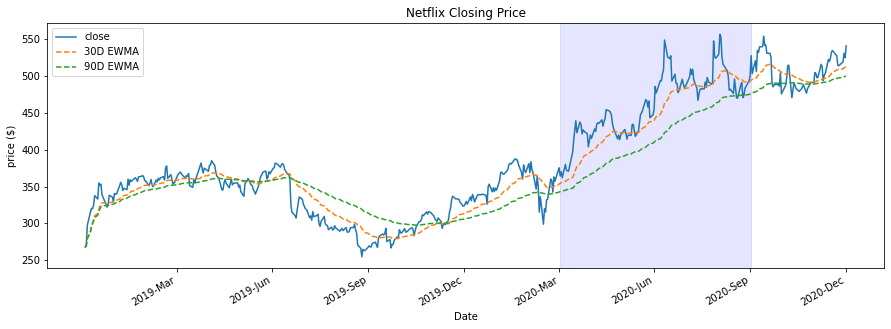

In [6]:
ax = netflix_viz.plot_moving_averages(
    type_='EWMA',
    column='close', 
    periods=['30D', '90D'],
)
ax = utils_viz.plot_shaded_region(
    ax=ax, 
    x=('2020-04-01', '2020-10-01'), 
    color='blue', 
    alpha=0.1
)
ax.set(
    title='Netflix Closing Price', 
    ylabel='price ($)'
)

Let's take a look at the effect of after-hours trading:

<AxesSubplot:title={'center':'After-Hours Trading - Monthly Effect'}, xlabel='Date', ylabel='Price'>

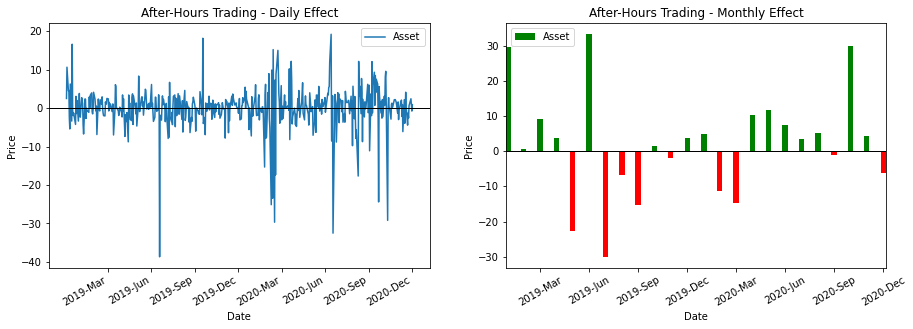

In [7]:
netflix_viz.plot_after_hours_trades()

We can use a **plot_candlestick plot** to study the OHLC data. More information on reading and interpreting this can be found [here](https://www.investopedia.com/trading/plot_candlestick-charting-what-is-it/).

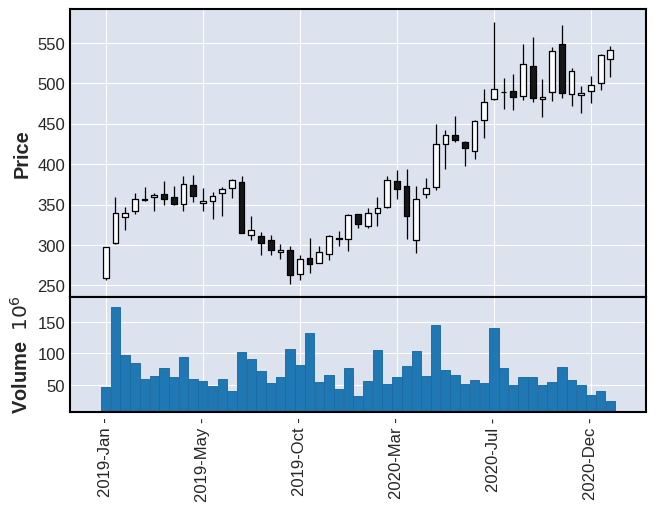

In [8]:
netflix_viz.plot_candlestick(
    resample='2W', 
    volume=True, 
    xrotation=90, 
    datetime_format='%Y-%b -'
)

The `mplfinance` package uses it's own stylesheets for plotting, so let's restore the defaults:

In [9]:
import matplotlib as mpl
mpl.rcdefaults()
%matplotlib inline

We can use a joint plot to see how Netflix compared to the S&P 500:

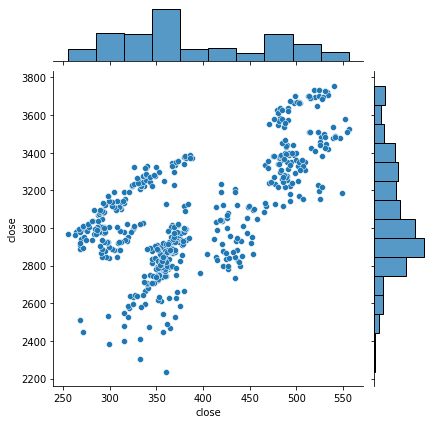

In [10]:
utils_viz.plot_jointplot(data=nflx, data2=sp, column='close')

We can also use the `plot_correlation_heatmap()` function to look at the correlation of daily percent change. Here, we compare with Amazon:

<AxesSubplot:>

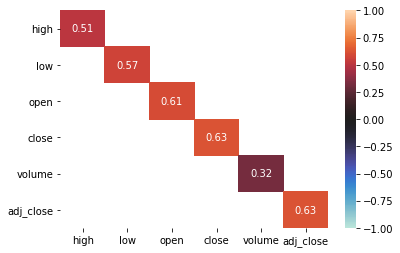

In [11]:
netflix_viz.plot_correlation_heatmap(amzn)

We can use the `plot_area_between_close_prices()` method to compare Netflix's stock price over time to another asset. Here, we look at Tesla:

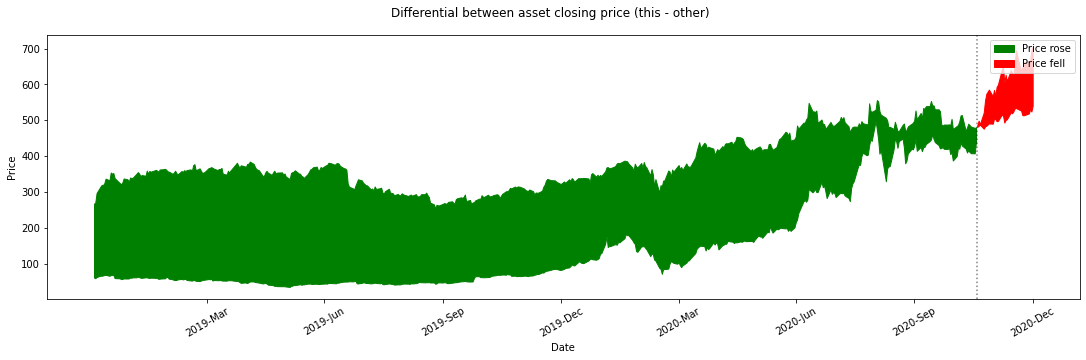

In [12]:
tsla = reader.get_ticker_data('TSLA')

change_date = (tsla.close > nflx.close).idxmax()

ax = netflix_viz.plot_between_closes(tsla)
ax = utils_viz.plot_reference_line(
    ax=ax, 
    x=change_date, 
    color='k', 
    linestyle=':', 
    label=f'TSLA > NFLX {change_date:%Y-%m-%d}',
    alpha=0.5
)


If we want to visualize groups of assets, we use the `AssetGroupVisualizer` class. Let's look at the correlations between the assets using percentage change:

<AxesSubplot:xlabel='name', ylabel='name'>

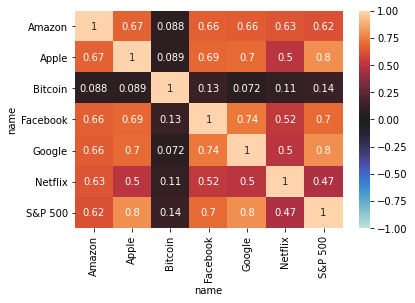

In [13]:
all_assets_viz = stock_analysis.AssetGroupVisualizer(all_assets)

all_assets_viz.plot_correlation_heatmap()

Bitcoin is on a much larger scale so we have to use subplots to compare it to the stock market:

<AxesSubplot:xlabel='Date', ylabel='Price'>

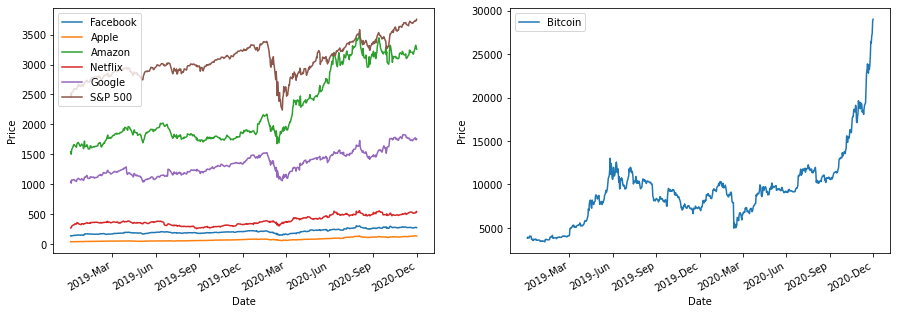

In [14]:
faang_sp_viz = stock_analysis.AssetGroupVisualizer(faang_sp)
bitcoin_viz = stock_analysis.StockVisualizer(bitcoin)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

faang_sp_viz.plot_curve(
    'close', 
    ax=axes[0], 
    style=faang_sp_viz.group_by
)
utils_viz.plot_curve(
    data=bitcoin.close, 
    ax=axes[1], 
    label='Bitcoin'
)


### Additional Plots (not in text)
We can view the effect that after-hours trading had on each of the FAANG stocks:

<AxesSubplot:title={'center':'After-Hours Trading - Monthly Effect'}, xlabel='Date', ylabel='Price'>

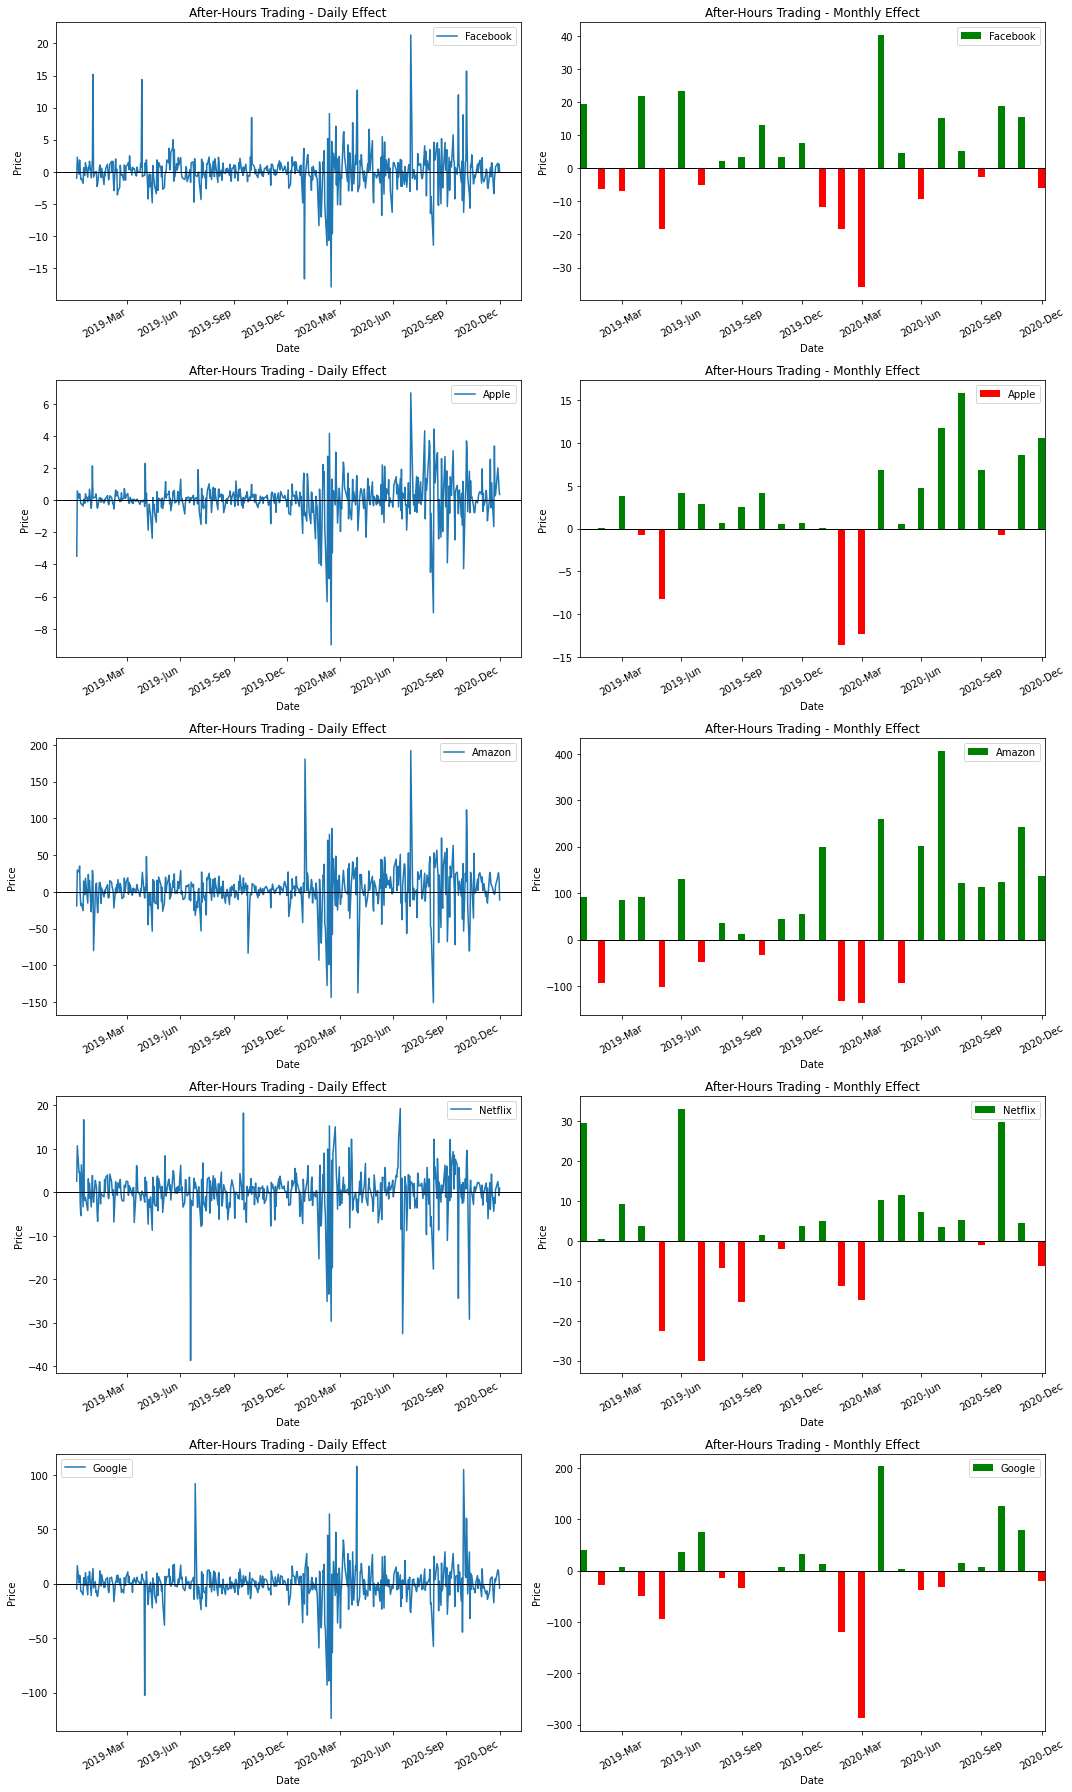

In [15]:
faang_viz = stock_analysis.AssetGroupVisualizer(faang)
faang_viz.plot_after_hours_trades()

We can look at what the exponentially smoothed moving averages look like for all FAANG stocks as well:

<AxesSubplot:xlabel='Date', ylabel='Price'>

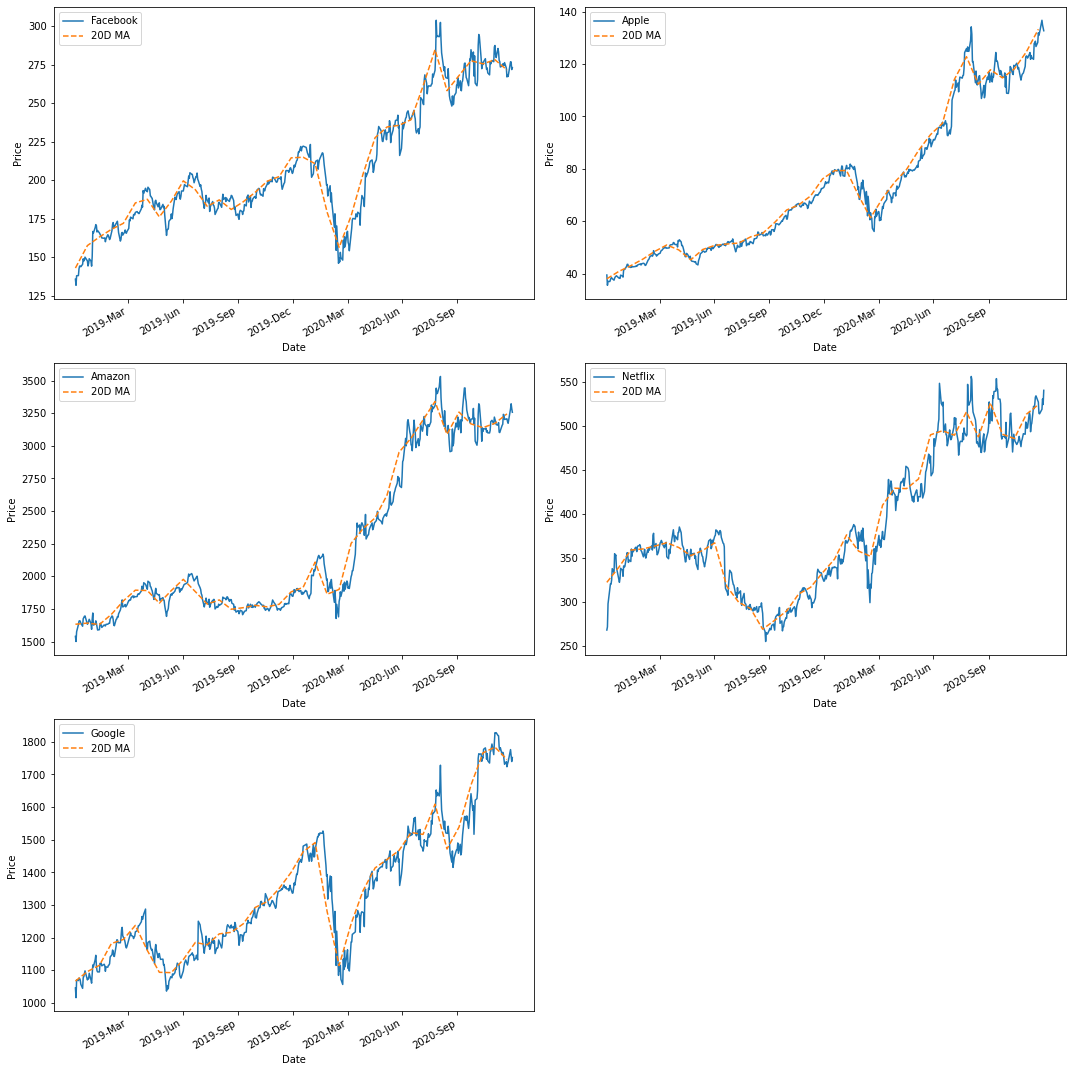

In [16]:
faang_viz.plot_moving_averages(
    type_='MA',
    column='close', 
    periods=['20D']
)

With short windows, both these smoothing methods perform similarly:

<AxesSubplot:xlabel='Date', ylabel='Price'>

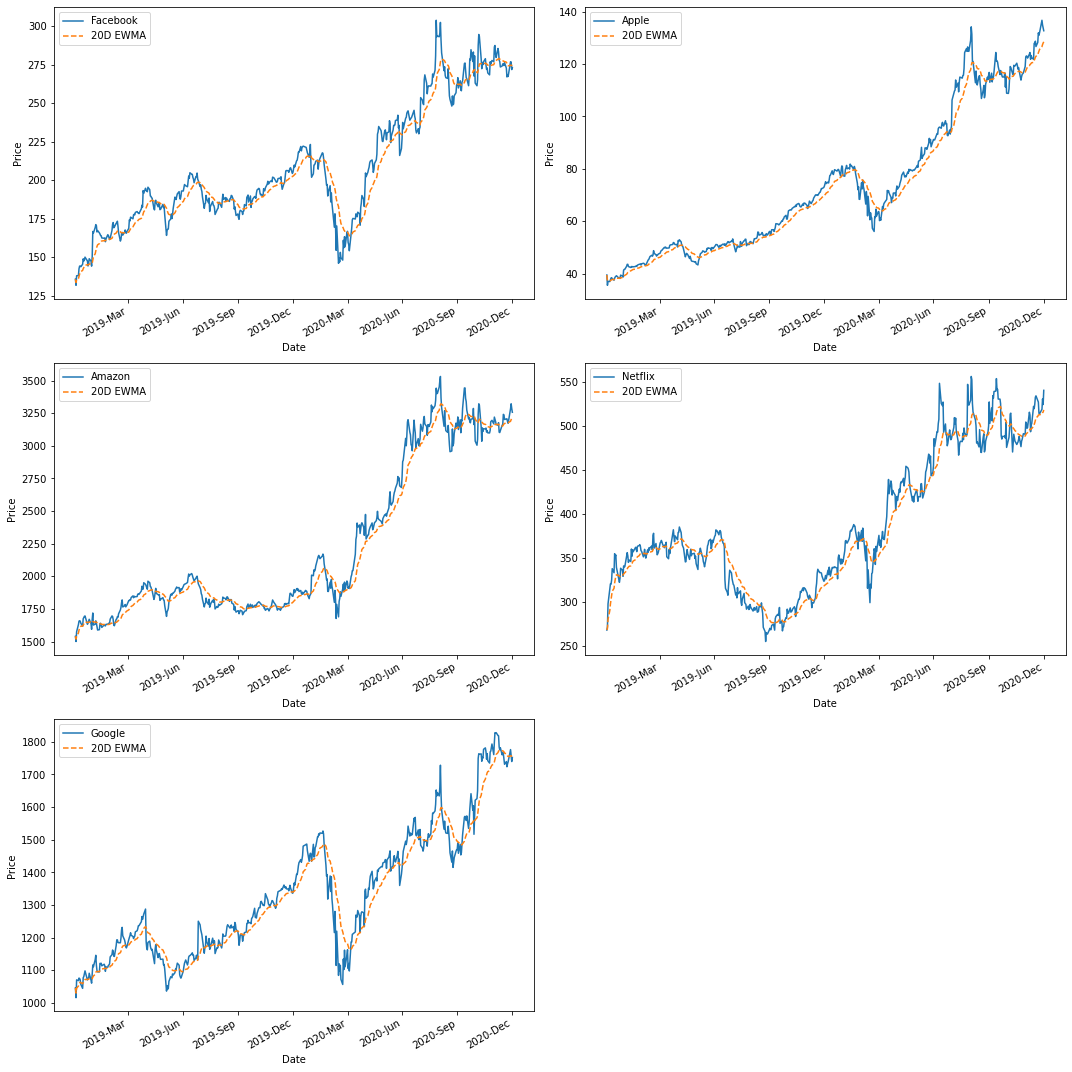

In [17]:
faang_viz.plot_moving_averages(
    type_='EWMA',
    column='close', 
    periods=['20D']
)

The distributions of closing price across the FAANG stocks are quite different:

array([[<AxesSubplot:title={'center':'Facebook'}, xlabel='close', ylabel='Count'>,
        <AxesSubplot:title={'center':'Apple'}, xlabel='close', ylabel='Count'>],
       [<AxesSubplot:title={'center':'Amazon'}, xlabel='close', ylabel='Count'>,
        <AxesSubplot:title={'center':'Netflix'}, xlabel='close', ylabel='Count'>],
       [<AxesSubplot:title={'center':'Google'}, xlabel='close', ylabel='Count'>,
        <AxesSubplot:>]], dtype=object)

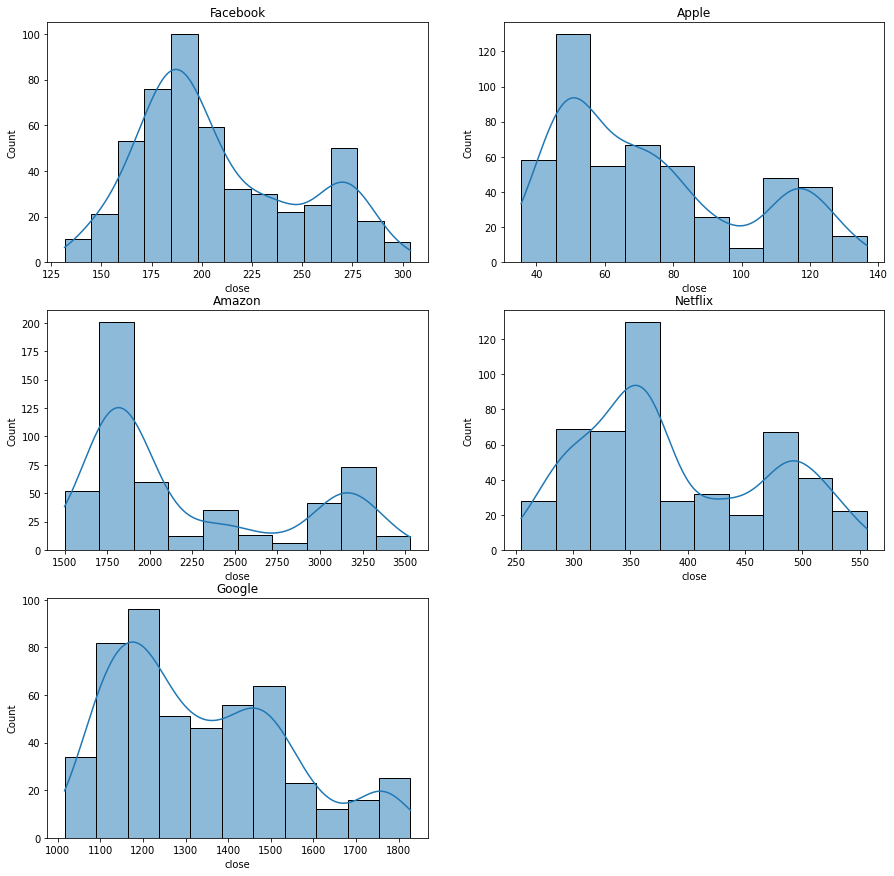

In [18]:
faang_viz.plot_histogram('close')

Viewing box plots we can easily see that Google and Amazon are on a much larger scale:

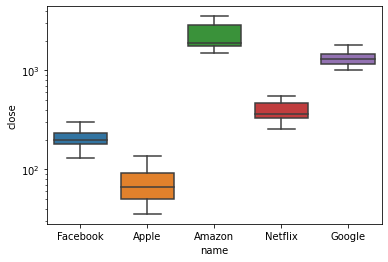

In [19]:
faang_viz.plot_boxplot('close')
plt.yscale('log')

Correlations between the stocks are weak:

<AxesSubplot:xlabel='name', ylabel='name'>

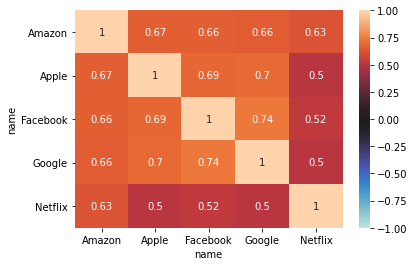

In [20]:
faang_viz.plot_correlation_heatmap()

We can view this information as scatter plots as well:

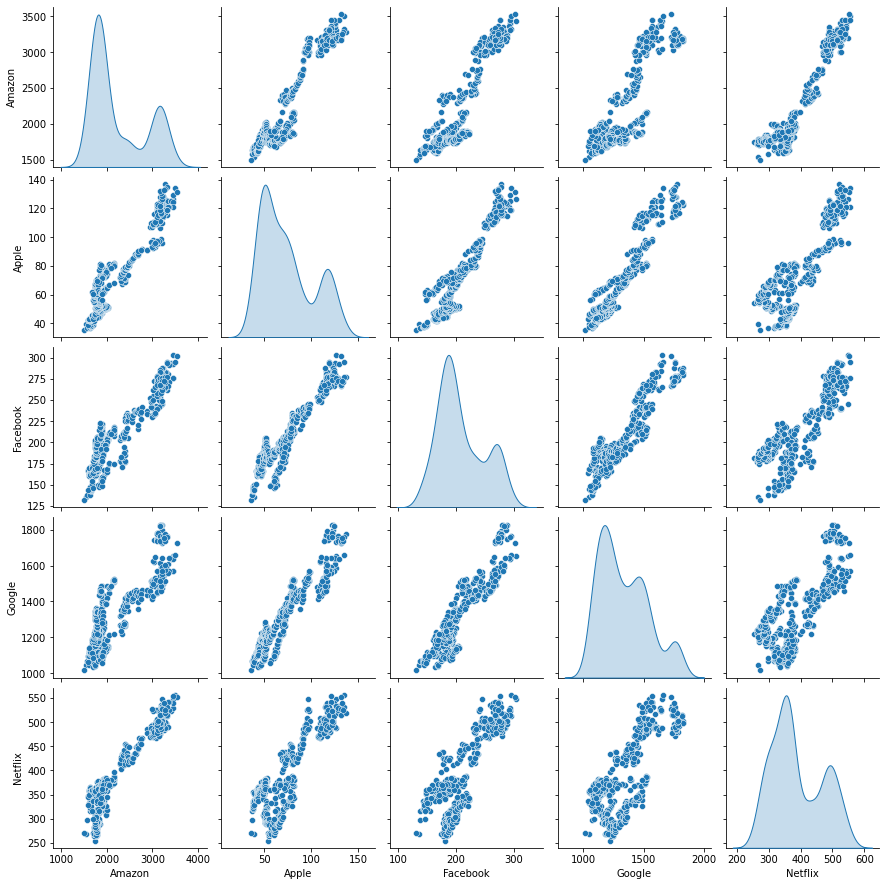

In [21]:
faang_viz.plot_pairplot()

## Technical Analysis
Technical analysis involves looking at metrics to understand the peformance of an asset.
### Single Asset
We can use the `StockAnalyzer` class to calculate metrics for us:

In [22]:
nflx_analyzer = stock_analysis.StockAnalyzer(nflx)

One such metric is annualized volatility:

In [23]:
nflx_analyzer.calc_annualized_volatility()

0.4626772090887299

### Asset Groups
When working with groups, we use the `AssetGroupAnalyzer` class:

In [24]:
all_assets_analyzer = stock_analysis.AssetGroupAnalyzer(all_assets)

#### Coefficient of Variation
We can check how large the standard deviation is in terms of the mean of the stock price as another way to look at volatility. This shows that bitcoin is the most volatile:

In [25]:
all_assets_analyzer.analyze('calc_cv')

{'Amazon': 0.2658012522278963,
 'Apple': 0.36991905161737615,
 'Bitcoin': 0.43597652683008137,
 'Facebook': 0.19056336194852783,
 'Google': 0.15038618497328074,
 'Netflix': 0.20344854330432688,
 'S&P 500': 0.09536374658108937}

#### Annualized Volatility

In [26]:
all_assets_analyzer.analyze('calc_annualized_volatility')

{'Amazon': 0.3851099077041784,
 'Apple': 0.4670809643500882,
 'Bitcoin': 0.4635140114227397,
 'Facebook': 0.45943066572169544,
 'Google': 0.3833720603377728,
 'Netflix': 0.4626772090887299,
 'S&P 500': 0.34491195196047003}

#### Bull Market
We can check if the assets are in a bull market, meaning their value increased $\geq$ 20% in the last 2 months:

In [27]:
all_assets_analyzer.analyze('is_bull_market')

{'Amazon': False,
 'Apple': True,
 'Bitcoin': True,
 'Facebook': False,
 'Google': False,
 'Netflix': False,
 'S&P 500': False}

#### Bear Market
We can check if the assets are in a bear market, meaning their value dropped $\geq$ 20% in the last 2 months:

In [28]:
all_assets_analyzer.analyze('is_bear_market')

{'Amazon': False,
 'Apple': False,
 'Bitcoin': False,
 'Facebook': False,
 'Google': False,
 'Netflix': False,
 'S&P 500': False}

#### Beta
Beta tells us how an asset's performance correlates to a market index. A beta of 1 with the S&P 500 means the asset moves with the S&P 500. Notice bitcoin is below one because it is a different type of asset.

In [29]:
all_assets_analyzer.analyze(
    'calc_beta', 
    index=sp
)

{'Amazon': 0.7563691182389215,
 'Apple': 1.173273501105917,
 'Bitcoin': 0.3716024282483361,
 'Facebook': 1.0245928218547518,
 'Google': 0.9862076250402396,
 'Netflix': 0.7408228073823281,
 'S&P 500': 0.9999999999999994}

#### Alpha
Alpha allows us to compare the returns of an asset to an index. We can compare to the S&P 500 using the risk-free rate of return. You can look up rates [here](https://www.treasury.gov/resource-center/data-chart-center/interest-rates/pages/TextView.aspx?data=yield) or use the `StockReader.get_risk_free_rate_of_return()` method. This shows that bitcoin much higher returns than the S&P 500 (due to scale) and Apple is the top performer among the FAANG stocks: 

In [30]:
risk_free_ror = reader.get_risk_free_rate_of_return()

all_assets_analyzer.analyze(
    'calc_alpha', 
    index=sp, 
    risk_free_ror=risk_free_ror
)


{'Amazon': 0.7383391908270167,
 'Apple': 1.7801122522388662,
 'Bitcoin': 6.355297988074054,
 'Facebook': 0.5048625273190837,
 'Google': 0.18537197824248108,
 'Netflix': 0.6500392764754637,
 'S&P 500': 2.7755575615628914e-16}

#### Cumulative Returns
Cumulative returns show us what we would have made for a dollar investment at time period 0. This can be multiplied by the actual investment to get the return:

Text(0.5, 0.98, 'Cumulative Returns')

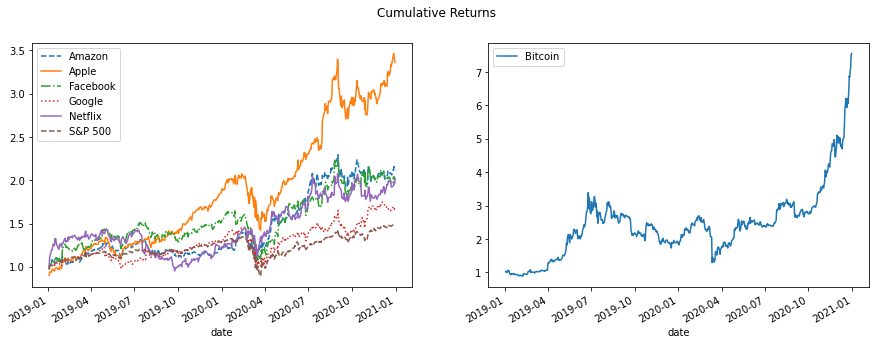

In [31]:
from cycler import cycler

# To make this a little easier to see in the black and white text

colors = list(
    plt.get_cmap('tab10')(x/10) 
    for x in range(10)
)
linestyles = ['dashed', 'solid', 'dashdot', 'dotted', 'solid']

bw_viz_cycler = (
    cycler(color=colors) + cycler(linestyle=linestyles*2)
)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].set_prop_cycle(bw_viz_cycler)

cumulative_returns = all_assets_analyzer.analyze('calc_cumulative_returns')

for name, data in cumulative_returns.items():
    data.plot(
        ax=axes[1] if name == 'Bitcoin' else axes[0], 
        label=name,
        legend=True
    )
fig.suptitle('Cumulative Returns')

## Modeling
For modeling tasks, we can use the `StockModeler` class:

In [32]:
from stock_analysis import StockModeler

### Time Series Decomposition
We can decompose the Netflix time series into its trend, seasonality component, and residuals:

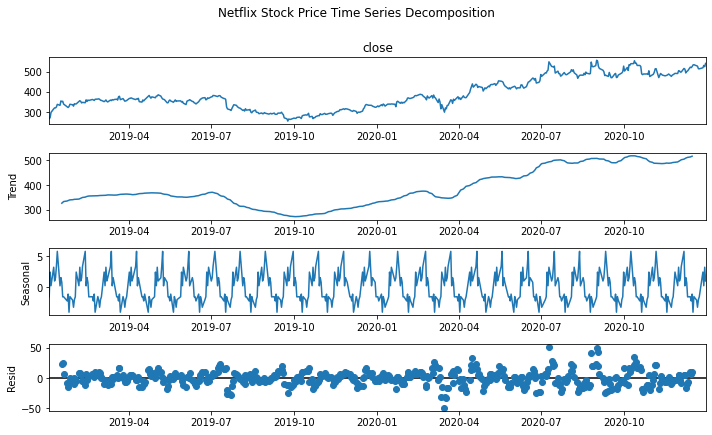

In [33]:
decomposition = StockModeler.create_decompose_object(nflx, 20) # 20 period frequency

fig = decomposition.plot()
fig.suptitle('Netflix Stock Price Time Series Decomposition', y=1)
fig.set_figheight(6)
fig.set_figwidth(10)
fig.tight_layout()


### ARIMA
We can use ARIMA to model the performance with autoregressive (AR), differences or lagged data (I), and moving average (MA) terms. The autocorrelation plot can help find a good starting point for this:

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

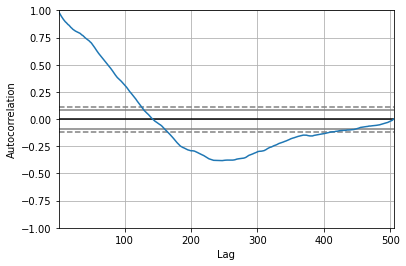

In [34]:
# We can use autocorrelation plots to find a good starting point for ARIMA

from pandas.plotting import autocorrelation_plot
autocorrelation_plot(nflx.close)

Lag plots can also be helpful:

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

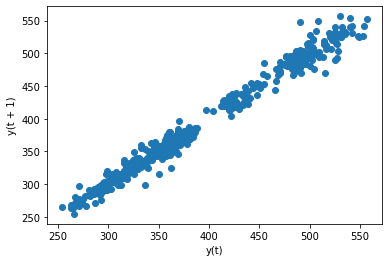

In [35]:
from pandas.plotting import lag_plot
lag_plot(nflx.close)

ARIMA takes a long time to train, so we will start with an AR of 10:

In [36]:
%%capture
# This takes a long time to run, so we will start with a smaller AR of 10

arima_model = StockModeler.create_arima_model(nflx, ar=10, i=1, ma=5)

The `summary()` method shows statistics on the model's performance:

In [37]:
# AR = 10, I = 1, MA = 5
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  522
Model:                ARIMA(10, 1, 5)   Log Likelihood               -1925.948
Date:                Tue, 19 Oct 2021   AIC                           3883.896
Time:                        17:24:33   BIC                           3951.988
Sample:                    01-02-2019   HQIC                          3910.568
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1356      0.286     -0.474      0.636      -0.697       0.426
ar.L2          0.1000      0.257      0.389      0.697      -0.404       0.604
ar.L3         -0.2888      0.216     -1.340      0.1

The residuals appear to be normally distributed (right subplot); however, their size appears to depend on time (left subplot), so this may not be a good model:

array([<AxesSubplot:title={'center':'Residuals'}, xlabel='Date', ylabel='Residual'>,
       <AxesSubplot:title={'center':'Residuals KDE'}, xlabel='Residual', ylabel='Density'>],
      dtype=object)

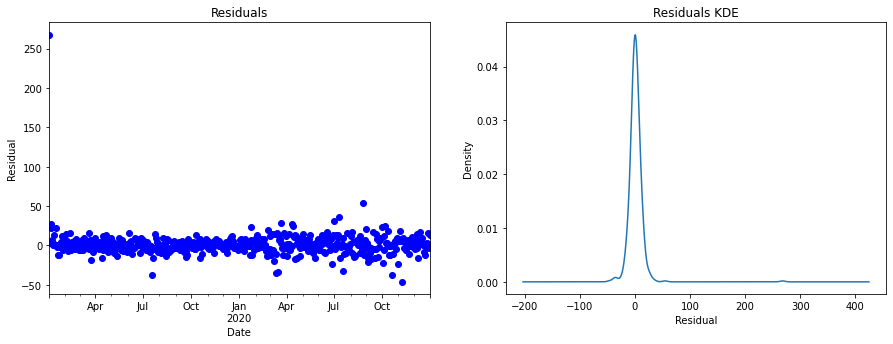

In [38]:
StockModeler.plot_residuals(arima_model)

### Linear Regression
We can build a linear regression using the last value to determine the next value:

In [39]:
X, Y, lm = StockModeler.create_linear_regression_model(nflx)
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:                  close   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          7.470e+05
Date:                Tue, 19 Oct 2021   Prob (F-statistic):                        0.00
Time:                        17:24:35   Log-Likelihood:                         -1889.3
No. Observations:                 504   AIC:                                      3781.
Df Residuals:                     503   BIC:                                      3785.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Once again, the residuals appear to depend on time:

array([<AxesSubplot:title={'center':'Residuals'}, xlabel='Date', ylabel='Residual'>,
       <AxesSubplot:title={'center':'Residuals KDE'}, xlabel='Residual', ylabel='Density'>],
      dtype=object)

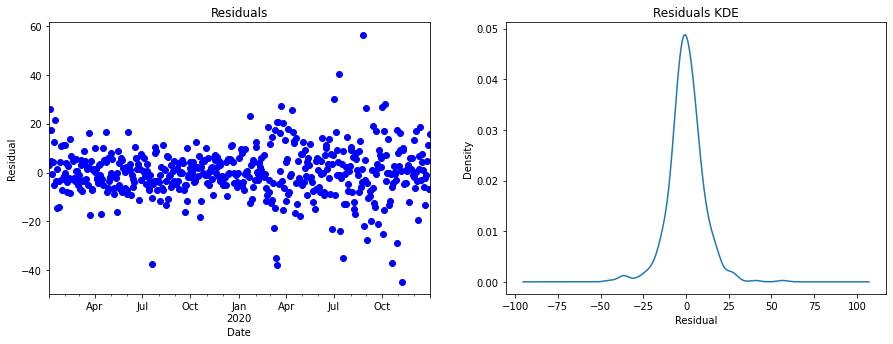

In [40]:
StockModeler.plot_residuals(lm)

### Compare Models Against Actuals
Let's see how these models compared to what actually happened:

Text(0, 0.5, 'price ($)')

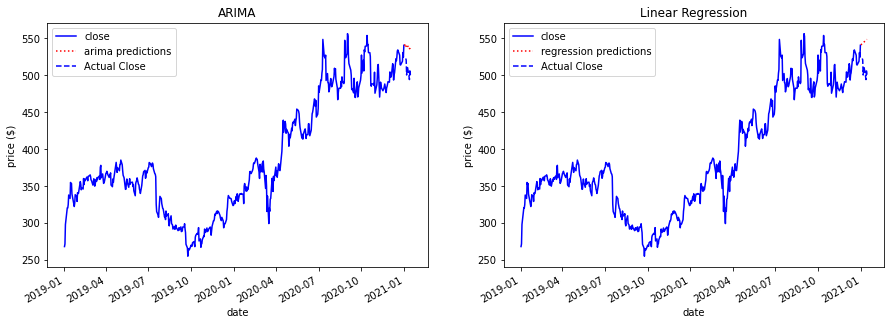

In [41]:
import datetime as dt

start = dt.date(2021, 1, 1)
end = dt.date(2021, 1, 14)

jan = stock_analysis\
    .StockReader(start, end)\
    .get_ticker_data('NFLX')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

arima_ax = StockModeler.calc_arima_predictions(
    nflx, 
    arima_model, 
    start=start, 
    end=end,
    ax=axes[0], 
    title='ARIMA', 
    color='b'
)

jan.close.plot(
    ax=arima_ax, 
    style='b--', 
    label='Actual Close'
)
arima_ax.legend()
arima_ax.set_ylabel('price ($)')

linear_reg = StockModeler.calc_linear_regression_predictions(
    nflx, 
    lm, 
    start=start, 
    end=end,
    ax=axes[1], 
    title='Linear Regression', 
    color='b'
)
jan.close.plot(
    ax=linear_reg, 
    style='b--', 
    label='Actual Close')
linear_reg.legend()
linear_reg.set_ylabel('price ($)')
